#Institute for Machine Learning, LLC
## **Author:** Dr. Giancarlo Crocetti
## **Course:** AIM-315 Introduction to Business Analytics


**License**: This code is licensed under the Creative Common License for non-commercial use **CC BY-NC**. Refer to https://creativecommons.org/licenses/by-nc/2.0/ for more information.



# 📈 ARIMA Modeling of Stock Prices (with Alpha Vantage “Vintage” API)
**Traditional ML on Financial Time Series**

## Problem Statement
You are an analyst working on predicting stock prices applying **traditional machine learning** tools to **financial time series**. In this notebook, you will:

1. Retrieve daily adjusted stock prices using the **Alpha Vantage API**
2. Perform an **ARIMA** analysis to model the log-price dynamics.
3. Use **ACF** and **PACF** plots to propose candidate orders for the ARIMA model (parameters **p**, **d**, **q**).
4. Systematically evaluate candidate models and **select the best** via **AIC** and **BIC**.
5. Produce **forecasts** and perform **residual diagnostics** (whiteness and normality checks).
6. Conclude with guidance and recommendations for sound modeling in financial contexts.

> **Educational note:** Prices are typically **non-stationary**; ARIMA often requires differencing (**d ≥ 1**) when modeling the **levels**. Many practitioners prefer modeling **returns** (often stationary with **d = 0**). Here, we illustrate the ARIMA pipeline on **log-price** levels, letting the data determine **d** via stationarity tests.  
> **Disclaimer:** This notebook is for **educational purposes** and **is not financial advice**.



## 1. Library Used in this Notebook
This analysis requires the following libraries:
- `pandas`, `numpy` for data handling  
- `matplotlib` for plotting  
- `statsmodels` for ARIMA, ADF/KPSS tests, and ACF/PACF  
- `requests` to call the Alpha Vantage REST API

> If you don't have an Alpha Vantage key yet, get a free one at their website and paste it below.


In [29]:

# If running on Colab, most packages are already available. If you need to install, uncomment:
# !pip install statsmodels requests pandas matplotlib

import os
import json
import math
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import yfinance as yf
from google.colab import userdata
from pandas.tseries.offsets import BDay

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams['figure.figsize'] = (10, 4)
pd.options.display.float_format = '{:,.6f}'.format


## 2.a Retrieve Stock Data using Yahoo Finance
While Alpha Vantage allows the retrieval of various traded commodities across several markets, it might require a premius access. Yahoo Finance is a good alternative in case the stock you selected falls into the premious list.

In [30]:
# Utility function to retrieve from-to dates for stock data
def get_date_range_by_business_days(start_date_str: str, num_periods: int) -> tuple[str, str]:
    """
    Given a start date string and a number of business days, returns a tuple
    of two date strings (start_date, end_date) where end_date is num_periods
    business days from start_date. If num_periods is negative, the dates are
    swapped to ensure the first date is before the second.

    Args:
        start_date_str: The starting date as a string in 'YYYY-MM-DD' format.
        num_periods: The number of business days to add (can be negative).

    Returns:
        A tuple of two date strings (date1, date2) where date1 <= date2.
    """
    start_date = pd.to_datetime(start_date_str)

    if num_periods >= 0:
        end_date = start_date + BDay(num_periods)
        date1_str = start_date.strftime('%Y-%m-%d')
        date2_str = end_date.strftime('%Y-%m-%d')
    else:
        end_date = start_date + BDay(num_periods)
        date1_str = end_date.strftime('%Y-%m-%d')
        date2_str = start_date.strftime('%Y-%m-%d')

    return (date1_str, date2_str)

print(get_date_range_by_business_days('2021-01-01', 500))
print(get_date_range_by_business_days('2021-01-15', -5))

('2021-01-01', '2022-12-02')
('2021-01-08', '2021-01-15')


In [31]:
def get_stock_data(symbol: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Downloads Yahoo Finance historical data for a single stock symbol.

    Args:
        symbol: The stock ticker symbol.
        start_date: Optional start date string in 'YYYY-MM-DD' format.
        end_date: Optional end date string in 'YYYY-MM-DD' format.

    Returns:
        A pandas DataFrame with Date as the index and columns for open, high,
        low, close, adjusted_close, and volume, all in lowercase.
    """
    # Download data for the single symbol
    df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Ensure Date is the index (it usually is by default with yfinance)
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Handle potential MultiIndex columns by flattening before lowercasing
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns.values] # Flatten MultiIndex to string

    # Convert column names to lowercase
    df.columns = df.columns.str.lower()

    # Rename 'adj close' to 'adjusted_close' if it exists
    if 'adj close' in df.columns:
        df = df.rename(columns={'adj close': 'adjusted_close'})

    # Select and reorder relevant columns
    # Ensure all expected columns exist before selecting
    required_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
    for col in required_cols:
        if col not in df.columns:
            # Handle cases where a column might be missing (e.g., for very new stocks)
            # For this context, we might raise an error or log a warning
            print(f"Warning: Column '{col}' not found for symbol {symbol}. Skipping.")
            # Or, add the column with NaNs
            # df[col] = np.nan

    # Filter for required columns that are actually present
    cols_to_select = [col for col in required_cols if col in df.columns]
    df = df[cols_to_select]


    return df


## 2.b Configure the Alpha Vantage (“Vintage”) API
- Paste your API key into the cell below or set it as an environment variable named `ALPHAVANTAGE_API_KEY`.
- Choose a ticker symbol (e.g., `AAPL`, `MSFT`, `TSLA`, `SPY`).

**Why Alpha Vantage?** It’s a simple, (not-always) free REST API widely used for academic projects.


In [32]:
# Read the API key from Google Colab secrets.
ALPHAVANTAGE_API_KEY = userdata.get('ALPHAVANTAGE_API_KEY')

if not ALPHAVANTAGE_API_KEY:
    # Try to read the environment variable
    ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "REPLACE_WITH_YOUR_KEY")
else:
    print("Using Google Colab secrets.")

Using Google Colab secrets.


In [33]:
# Setting up the stock symbol to use and the periods to consider
tickers = ["NVDA", "FSLR", "MSFT", "TSLA", "SPY"] # Possible stocks to analyze
SYMBOL = tickers[0]
PERIODS = 500
START_DATE = '2021-01-01'

# Optional: compact vs full (full returns all history, compact ~100 days)
OUTPUT_SIZE = "full"  # "full" or "compact"

# Basic validation
if ALPHAVANTAGE_API_KEY == "REPLACE_WITH_YOUR_KEY":
    print("Please set ALPHAVANTAGE_API_KEY (above) to your real Alpha Vantage key.")
else:
    print("API key detected.")
print(f"Using symbol: {SYMBOL}")


API key detected.
Using symbol: NVDA



## 3. Retrieve Daily Adjusted Prices
We call Alpha Vantage's `TIME_SERIES_DAILY_ADJUSTED` endpoint and convert the JSON into a clean `pandas.DataFrame` sorted by date.

**Adjusted close** is used because it accounts for dividends and splits, producing a more consistent price series for modeling.


In [34]:
def fetch_alpha_vantage_daily_adjusted(symbol: str, apikey: str, output_size: str = "compact", start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Fetch TIME_SERIES_DAILY_ADJUSTED from Alpha Vantage.
    Returns a DataFrame with columns: ['open','high','low','close','adjusted_close','volume','dividend_amount','split_coefficient']
    indexed by pandas datetime in ascending order, filtered by start and end dates if provided.
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": symbol,
        "apikey": apikey,
        "outputsize": output_size
    }
    r = requests.get(url, params=params)
    if r.status_code != 200:
        raise RuntimeError(f"HTTP error {r.status_code}: {r.text}")
    data = r.json()

    if "Error Message" in data:
        raise ValueError(f"API returned error: {data['Error Message']}")
    if "Time Series (Daily)" not in data:
        raise ValueError(f"Unexpected payload (rate limit or invalid key?): {json.dumps(data)[:500]}")


    ts = data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(ts, orient="index", dtype=float)
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adjusted_close",
        "6. volume": "volume",
        "7. dividend amount": "dividend_amount",
        "8. split coefficient": "split_coefficient"
    })
    df = df.sort_index()  # ascending

    # Filter by date range if start_date or end_date are provided
    if start_date:
        start_datetime = pd.to_datetime(start_date)
        df = df[df.index >= start_datetime]
    if end_date:
        end_datetime = pd.to_datetime(end_date)
        df = df[df.index <= end_datetime]

    return df

Getting the data ...

In [35]:
try:
    df = fetch_alpha_vantage_daily_adjusted(SYMBOL,
                                            ALPHAVANTAGE_API_KEY,
                                            output_size=OUTPUT_SIZE,
                                            start_date=START_DATE,
                                            end_date=get_date_range_by_business_days(START_DATE, PERIODS)[1])
except:
    # You found a stock that requires a premium access to the Alpha Vantage API. Rollback to the Yahoo Finance API
    df = get_stock_data(SYMBOL, start_date=START_DATE, end_date=get_date_range_by_business_days(START_DATE,PERIODS)[1])

print(df.head(3))
print(df.tail(3))

                open      high       low     close  adjusted_close     volume
Date                                                                         
2021-01-04 13.104250 13.652500 12.962500 13.113500       13.078190  560640000
2021-01-05 13.099750 13.443500 13.087000 13.404750       13.368657  322760000
2021-01-06 13.222500 13.245000 12.586000 12.614500       12.580534  580424000
                open      high       low     close  adjusted_close     volume
Date                                                                         
2022-11-29 15.827000 15.932000 15.520000 15.639000       15.621113  298384000
2022-11-30 15.697000 16.930000 15.597000 16.923000       16.907972  565298000
2022-12-01 16.999001 17.264999 16.635000 17.135000       17.119783  470977000



## 4. Exploratory Data Analysis (EDA)
We plot the **Adjusted Close** and **log-price**. ARIMA on levels often uses **log-transformed** prices to stabilize variance, and differencing (the `d` parameter) handles the trend.


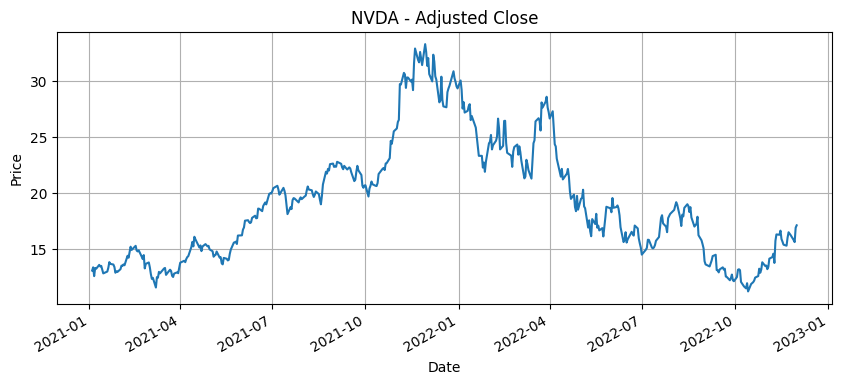

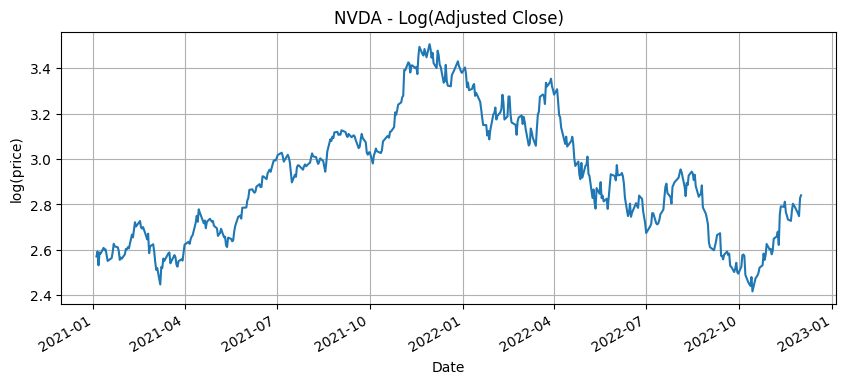

In [36]:

# Basic EDA plots
df = df.dropna(subset=["adjusted_close"]).copy()
df["log_price"] = np.log(df["adjusted_close"])

ax = df["adjusted_close"].plot(title=f"{SYMBOL} - Adjusted Close", grid=True)
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()

ax = df["log_price"].plot(title=f"{SYMBOL} - Log(Adjusted Close)", grid=True)
ax.set_xlabel("Date"); ax.set_ylabel("log(price)")
plt.show()



## 5. Stationarity & Choosing **d**
ARIMA requires the underlying series (after differencing `d` times) to be **stationary**.

We will determine `d` by:
1. Running **ADF (Augmented Dickey–Fuller)** and **KPSS** tests.
2. If non-stationary, difference the **log-price** and test again.
3. Stop when both tests indicate stationarity or we reach `d = 2`.

> **Rule of thumb for interpretation**  
> - **ADF** null: *unit root present* (non-stationary). We want **p-value < 0.05** to **reject** non-stationarity.  
> - **KPSS** null: *trend-stationary*. We want **p-value > 0.05** to **fail to reject** stationarity.


In [37]:
def adf_kpss_report(series: pd.Series, name: str = "series") -> Tuple[float, float]:
    """Run ADF & KPSS and print a compact summary. Returns (adf_p, kpss_p)."""
    series = series.dropna()
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag="AIC")
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression="c", nlags="auto")
    print(f"\n=== Stationarity Report for {name} ===")
    print(f"ADF:  stat={adf_stat: .4f}, p={adf_p: .4f} | crit={adf_crit}")
    print(f"KPSS: stat={kpss_stat: .4f}, p={kpss_p: .4f} | crit={kpss_crit}")
    return adf_p, kpss_p

# Determine d by iteratively differencing the log-price
y = df["log_price"].copy()
d = 0
max_d = 2

while d <= max_d:
    adf_p, kpss_p = adf_kpss_report(y, name=f"log_price differenced {d} times")
    adf_ok = adf_p < 0.05     # reject unit root
    kpss_ok = kpss_p > 0.05   # fail to reject stationarity

    if adf_ok and kpss_ok:
        print(f"\nSelected d = {d} (series appears stationary)." )
        break
    else:
        d += 1
        if d > max_d:
            print("\nReached maximum differencing (d=2). Proceeding with d=2 even if borderline.")
            d = max_d
            break
        y = y.diff()  # difference once and test again

# Keep a reference to the stationary (d-differenced) series for ACF/PACF
y_stationary = df["log_price"].diff(d).dropna() if d > 0 else df["log_price"].dropna()



=== Stationarity Report for log_price differenced 0 times ===
ADF:  stat=-1.6738, p= 0.4447 | crit={'1%': np.float64(-3.4439899743408136), '5%': np.float64(-2.8675550551408353), '10%': np.float64(-2.569973792117904)}
KPSS: stat= 0.8465, p= 0.0100 | crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

=== Stationarity Report for log_price differenced 1 times ===
ADF:  stat=-22.6766, p= 0.0000 | crit={'1%': np.float64(-3.4440184853599876), '5%': np.float64(-2.867567599912013), '10%': np.float64(-2.5699804779975883)}
KPSS: stat= 0.2195, p= 0.1000 | crit={'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Selected d = 1 (series appears stationary).


/tmp/ipython-input-3901060952.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression="c", nlags="auto")
/tmp/ipython-input-3901060952.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression="c", nlags="auto")



## 6. ACF & PACF to propose **p** and **q**
- **PACF** sharp cutoff after lag *p* suggests AR(**p**).  
- **ACF** sharp cutoff after lag *q* suggests MA(**q**).  
- **Gradual tails** in ACF/PACF can indicate mixed ARMA structures.

We do **not** select the model solely from these plots; we use them to **narrow the search**, then **validate with AIC/BIC**.


<Figure size 1200x400 with 0 Axes>

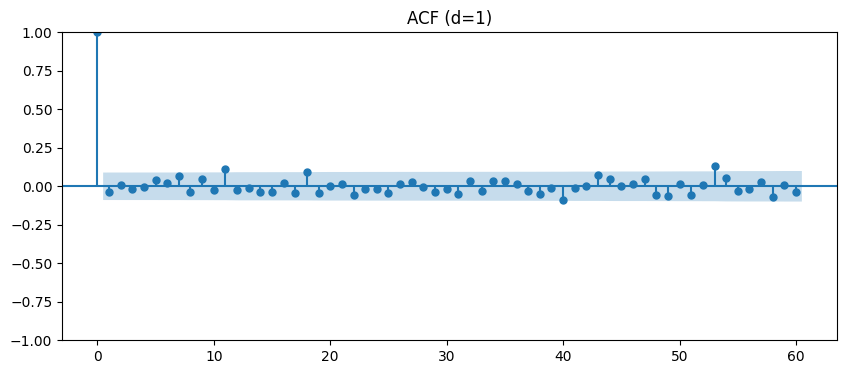

<Figure size 1200x400 with 0 Axes>

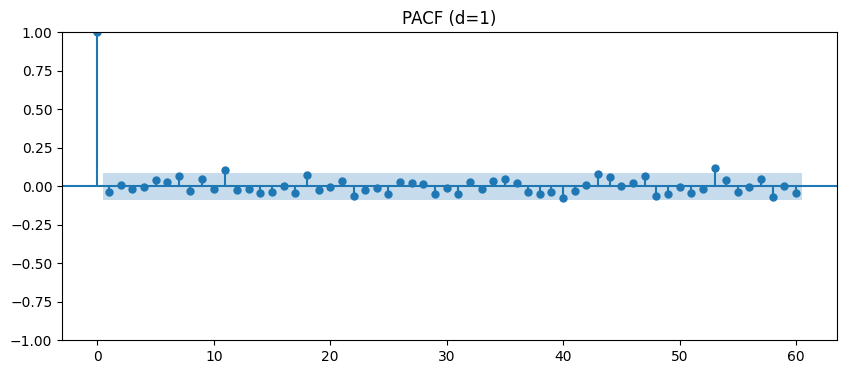

In [38]:

# Plot ACF & PACF for the differenced log-price
lags = min(60, len(y_stationary) // 4)

fig = plt.figure(figsize=(12, 4))
plot_acf(y_stationary, lags=lags, title=f"ACF (d={d})")
plt.show()

fig = plt.figure(figsize=(12, 4))
plot_pacf(y_stationary, lags=lags, title=f"PACF (d={d})", method="ywm")
plt.show()



## 7. Candidate Search & Information Criteria (AIC/BIC)

You could select the values from the plot; however, it might be hard to see if a point falls outside or within the band.

We fit a grid of ARIMA(**p**, **d**, **q**) models over a modest range and record **AIC** and **BIC**.  
The **lowest AIC/BIC** indicate relatively better models **(penalizing complexity)**.

**Grid** (feel free to adjust for speed/accuracy tradeoffs):
- `p ∈ {0,1,2,3,4,5}`  
- `q ∈ {0,1,2,3,4,5}`  
- `d` is fixed from the stationarity step above.


In [39]:
import warnings

# Store the original warnings filter
original_filters = warnings.filters[:]

# Temporarily change the filter for ConvergenceWarning within this cell's execution
warnings.filterwarnings("always", "DeprecationWarning")


def fit_arima_grid(y_original: pd.Series, d: int, p_max: int = 5, q_max: int = 5,
                   enforce_stationarity: bool = False, enforce_invertibility: bool = False) -> pd.DataFrame:
    """
    Fit ARIMA(p,d,q) for p in [0..p_max], q in [0..q_max] with fixed d.
    Returns a DataFrame with rows: (p,d,q,AIC,BIC) sorted by AIC.
    """
    results = []

    # Ensure the series has no NaNs and a DatetimeIndex
    y_clean = y_original.dropna().copy()
    if not isinstance(y_clean.index, pd.DatetimeIndex):
         y_clean.index = pd.to_datetime(y_clean.index)

    # Attempt to set frequency to 'B' (Business daily) - important for forecasting
    # If setting frequency fails, statsmodels might still handle it with freq='B' parameter
    try:
        y_clean = y_clean.asfreq('B')
        print("Successfully set frequency to 'B'.")
    except ValueError:
        print("Could not set frequency to 'B'. Proceeding without explicit frequency on index.")
        # If asfreq fails, y_clean retains its original index (hopefully DatetimeIndex)


    for p in range(p_max + 1):
        for q in range(q_max + 1):
            order = (p, d, q)
            try:
                # Fit ARIMA on the cleaned series without specifying freq in the constructor
                model = ARIMA(y_clean, order=order, enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility)
                fitted = model.fit() # Removed maxiter here
                results.append({
                    "p": p, "d": d, "q": q,
                    "aic": fitted.aic,
                    "bic": fitted.bic
                })
                print(f"Fitted ARIMA{order}: AIC={fitted.aic:.2f}, BIC={fitted.bic:.2f}")
            except DeprecationWarning as w:
                 continue
            except Exception as e:
                print(f"ARIMA{order} failed: {e}")
                continue

    # Restore original warnings filter after the loop
    warnings.filters = original_filters

    if not results:
        print("No ARIMA models were successfully fit.")
        return pd.DataFrame() # Return empty DataFrame if no models fit

    res_df = pd.DataFrame(results).sort_values(by="aic", ascending=True).reset_index(drop=True)
    return res_df

grid_results = fit_arima_grid(df["log_price"], d=d, p_max=5, q_max=5)
display(grid_results.head(10))

Successfully set frequency to 'B'.
Fitted ARIMA(0, 1, 0): AIC=-1863.24, BIC=-1859.03
Fitted ARIMA(0, 1, 1): AIC=-1860.29, BIC=-1851.88
Fitted ARIMA(0, 1, 2): AIC=-1855.86, BIC=-1843.24
Fitted ARIMA(0, 1, 3): AIC=-1849.06, BIC=-1832.25
Fitted ARIMA(0, 1, 4): AIC=-1842.83, BIC=-1821.83
Fitted ARIMA(0, 1, 5): AIC=-1836.29, BIC=-1811.10
Fitted ARIMA(1, 1, 0): AIC=-1862.17, BIC=-1853.75
Fitted ARIMA(1, 1, 1): AIC=-1859.71, BIC=-1847.09
Fitted ARIMA(1, 1, 2): AIC=-1853.84, BIC=-1837.03
Fitted ARIMA(1, 1, 3): AIC=-1847.14, BIC=-1826.13
Fitted ARIMA(1, 1, 4): AIC=-1840.83, BIC=-1815.63
Fitted ARIMA(1, 1, 5): AIC=-1834.33, BIC=-1804.94
Fitted ARIMA(2, 1, 0): AIC=-1858.30, BIC=-1845.68
Fitted ARIMA(2, 1, 1): AIC=1913.38, BIC=1930.21
Fitted ARIMA(2, 1, 2): AIC=-1851.77, BIC=-1830.75
Fitted ARIMA(2, 1, 3): AIC=-1846.54, BIC=-1821.33
Fitted ARIMA(2, 1, 4): AIC=-1838.87, BIC=-1809.47
Fitted ARIMA(2, 1, 5): AIC=-1832.36, BIC=-1798.77
Fitted ARIMA(3, 1, 0): AIC=-1854.05, BIC=-1837.23
Fitted ARIMA(3, 1

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 1, 3): AIC=-1844.48, BIC=-1815.06
Fitted ARIMA(3, 1, 4): AIC=-1836.85, BIC=-1803.25
Fitted ARIMA(3, 1, 5): AIC=-1830.39, BIC=-1792.60
Fitted ARIMA(4, 1, 0): AIC=-1847.25, BIC=-1826.24
Fitted ARIMA(4, 1, 1): AIC=-1845.25, BIC=-1820.04


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 1, 2): AIC=-1827.07, BIC=-1797.66


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 1, 3): AIC=-1838.72, BIC=-1805.10
Fitted ARIMA(4, 1, 4): AIC=-1834.89, BIC=-1797.08


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(4, 1, 5): AIC=-1828.72, BIC=-1786.74
Fitted ARIMA(5, 1, 0): AIC=-1841.09, BIC=-1815.88
Fitted ARIMA(5, 1, 1): AIC=-1839.09, BIC=-1809.68


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 1, 2): AIC=-1837.26, BIC=-1803.66
Fitted ARIMA(5, 1, 3): AIC=-1832.53, BIC=-1794.73


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(5, 1, 4): AIC=-1834.61, BIC=-1792.60
Fitted ARIMA(5, 1, 5): AIC=-1830.48, BIC=-1784.30


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,d,q,aic,bic
0,0,1,0,"-1,863.242930","-1,859.034340"
1,1,1,0,"-1,862.170308","-1,853.753128"
2,0,1,1,"-1,860.294686","-1,851.881534"
3,1,1,1,"-1,859.713654","-1,847.093926"
4,2,1,0,"-1,858.301651","-1,845.681923"
5,0,1,2,"-1,855.855056","-1,843.241383"
6,3,1,0,"-1,854.045713","-1,837.227482"
7,1,1,2,"-1,853.843750","-1,837.025519"
8,3,1,1,"-1,852.084704","-1,831.061915"
9,2,1,2,"-1,851.771319","-1,830.748530"



## 8. Select Best Models
We select:
- **AIC winner**: the model with the smallest AIC  
- **BIC winner**: the model with the smallest BIC  

Then we **refit** each winner and inspect summaries and diagnostics.


In [40]:

if len(grid_results) == 0:
    raise RuntimeError("No ARIMA models were successfully fit. Adjust the grid or check data.")

best_aic_row = grid_results.iloc[0]
best_bic_row = grid_results.sort_values("bic").iloc[0]

order_aic = (int(best_aic_row.p), int(best_aic_row.d), int(best_aic_row.q))
order_bic = (int(best_bic_row.p), int(best_bic_row.d), int(best_bic_row.q))

print(f"Best by AIC: ARIMA{order_aic} (AIC={best_aic_row.aic:.2f}, BIC={best_aic_row.bic:.2f})")
print(f"Best by BIC: ARIMA{order_bic} (AIC={best_bic_row.aic:.2f}, BIC={best_bic_row.bic:.2f})")

model_aic = ARIMA(df["log_price"], order=order_aic).fit()
model_bic = ARIMA(df["log_price"], order=order_bic).fit()

print("=== Summary (AIC winner) ===")
print(model_aic.summary())

print("=== Summary (BIC winner) ===")
print(model_bic.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best by AIC: ARIMA(0, 1, 0) (AIC=-1863.24, BIC=-1859.03)
Best by BIC: ARIMA(0, 1, 0) (AIC=-1863.24, BIC=-1859.03)
=== Summary (AIC winner) ===
                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  483
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 938.375
Date:                Sun, 31 Aug 2025   AIC                          -1874.751
Time:                        21:14:55   BIC                          -1870.573
Sample:                             0   HQIC                         -1873.109
                                - 483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   6.77e-05     17.615      0.000       0.001 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



## 9. Residual Diagnostics
A good ARIMA model should have **white noise** residuals:
- **No autocorrelation** (Ljung–Box Q test p-values should be high).  
- Roughly **normal** (QQ plot).

We run these diagnostics for the chosen models.


ARIMA(0, 1, 0) (AIC winner): Ljung–Box test p-values
    lb_pvalue
10   0.999987
20   1.000000
30   1.000000


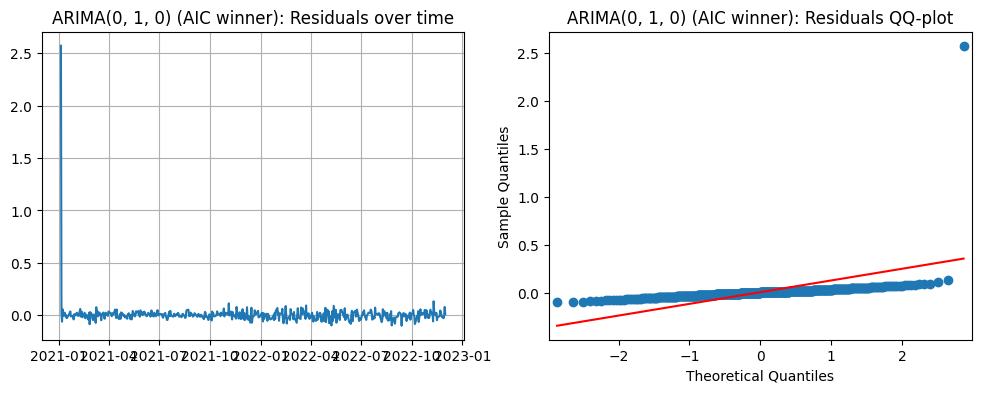

ARIMA(0, 1, 0) (BIC winner): Ljung–Box test p-values
    lb_pvalue
10   0.999987
20   1.000000
30   1.000000


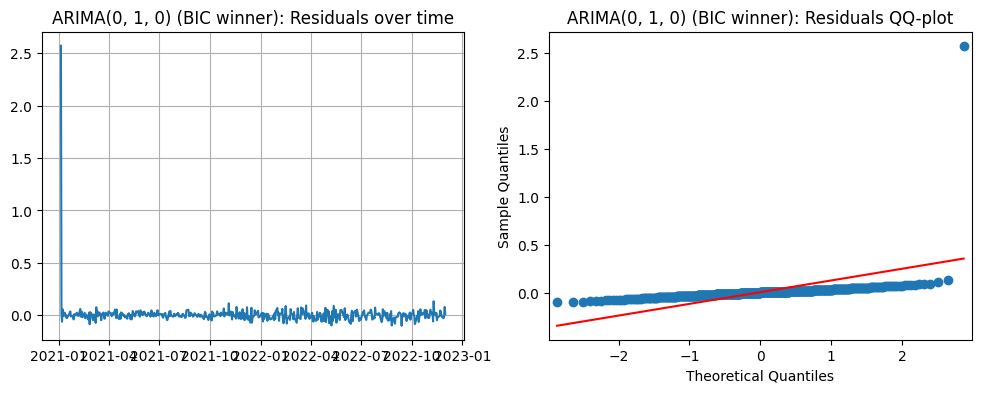

In [41]:

def residual_diagnostics(fitted_model, title_prefix="Model"):
    resid = fitted_model.resid.dropna()

    # Ljung-Box test for autocorrelation at multiple lags
    lags = [10, 20, 30]
    lb = acorr_ljungbox(resid, lags=lags, return_df=True)
    print(f"{title_prefix}: Ljung–Box test p-values")
    print(lb[["lb_pvalue"]])

    # Residual plots
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(resid)
    ax[0].set_title(f"{title_prefix}: Residuals over time"); ax[0].grid(True)

    # QQ plot
    from statsmodels.graphics.gofplots import qqplot
    qqplot(resid, line='s', ax=ax[1])
    ax[1].set_title(f"{title_prefix}: Residuals QQ-plot")
    plt.show()

residual_diagnostics(model_aic, title_prefix=f"ARIMA{order_aic} (AIC winner)")
residual_diagnostics(model_bic, title_prefix=f"ARIMA{order_bic} (BIC winner)")



## 10. Forecasting
We produce a **30-day** ahead forecast using the AIC-winning model. Since we modeled **log-prices**, we **exponentiate** the forecast to return to the original price scale.

> For practical trading or risk analysis, always consider **out-of-sample validation** and **rolling backtests**. A one-shot fit on all available history can overfit.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


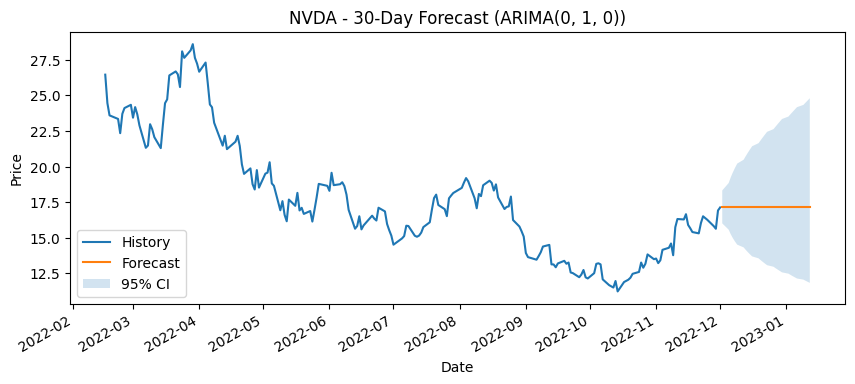

In [42]:
steps_ahead = 30
fcast = model_aic.get_forecast(steps=steps_ahead)

# Forecasts are on the log-price scale; convert to price
f_mean = fcast.predicted_mean
f_ci = fcast.conf_int(alpha=0.05)

# --- Ensure the forecast index is DatetimeIndex (avoid PeriodIndex converter conflicts) ---
# Generate a correct future index starting after the last date of historical data
last_hist_date = df.index[-1]
future_idx = pd.bdate_range(start=last_hist_date, periods=steps_ahead + 1)[1:] # Start after last_hist_date, exclude the first date

# Build price-scale series with the correct future DatetimeIndex using the values
f_mean_price = pd.Series(np.exp(f_mean.values), index=future_idx, name="Forecast")
f_ci_price = pd.DataFrame(np.exp(f_ci.values), index=future_idx, columns=f_ci.columns)

# Also ensure history uses DatetimeIndex
hist = df["adjusted_close"].iloc[-200:].copy()
hist.index = pd.to_datetime(hist.index)

# Plot without converter warnings
ax = hist.plot(label="History", grid=True, title=f"{SYMBOL} - 30-Day Forecast (ARIMA{order_aic})")
f_mean_price.plot(ax=ax, label="Forecast")
ax.fill_between(future_idx, f_ci_price.iloc[:, 0].values, f_ci_price.iloc[:, 1].values, alpha=0.2, label="95% CI")
ax.set_xlabel("Date")
ax.set_ylabel("Price"); ax.legend()
plt.show()

## 11. Model Analysis
To see the reason ARIMA gives a specific forecast, it is useful to analyze the coefficients.

In [43]:
last_diff = df["log_price"].diff().iloc[-1]
phi = model_aic.params.get("ar.L1", 0.0)
theta = model_aic.params.get("ma.L1", 0.0)

print("Last Δlog-price:", float(last_diff))
print("AR(1) φ:", float(phi))
print("MR(1) θ:", float(theta))

Last Δlog-price: 0.012449472307671794
AR(1) φ: 0.0
MR(1) θ: 0.0


# Observations

You might notice how the prediction is a flat line: why?

For an ARIMA(1,1,0) or ARIMA(0,1,1) on $y_t=log(price_t)$ we have that $\Delta y_t=\phi y_{t-1}+ϵ_t $ or $\Delta y_t=\theta y_{t-1}+ϵ_t $

With the AR(1) or MA(1) with small coefficients like a $\Delta y_t = -0.014451 $ and $ \phi=0.102 $, for example, the various forecasted points are nearly the same as the last showing as a flatted line.


## 11. Interpretation Checklist
When interpreting ARIMA results, consider:

- **Does the chosen `d` make sense?** Price levels are usually non-stationary, often implying **d = 1** for log-prices.  
- **Parameter significance:** Are AR/MA coefficients statistically significant?  
- **Residual diagnostics:** Are residuals white noise? If not, try alternative orders or consider **ARIMA with exogenous variables (ARIMAX)**.  
- **Volatility:** Financial returns often exhibit **heteroskedasticity**. Consider **GARCH-family** models for volatility modeling.  
- **Structural breaks & regimes:** Markets change. Consider **rolling windows**, **time-varying parameters**, or **regime-switching** models.  
- **Validation:** Use **time-series cross-validation** (e.g., expanding window) for robust model comparison beyond AIC/BIC.



## 12. Conclusions & Recommendations
- We used **Alpha Vantage** to download adjusted daily stock prices and applied **ARIMA** to **log-prices**.
- **ACF/PACF** helped suggest plausible **p**/**q** values, while **AIC/BIC** guided the final selection.
- Residual diagnostics indicated how well the model captured serial dependence; any remaining structure suggests trying different orders or adding exogenous signals.
- For capstone projects:
  1. **Document** your data pipeline (API calls, cleaning, transformations).
  2. **Justify** your differencing choice (`d`) with ADF/KPSS evidence.
  3. Use **AIC/BIC** for in-sample selection, **then** perform **out-of-sample** evaluation (rolling forecasts).
  4. Consider modeling **returns** (ARMA) for mean dynamics and **GARCH** for volatility, especially for risk-focused tasks.
  5. Report **assumptions and limitations** (non-stationarity, structural breaks, liquidity/holidays, survivorship bias).
- Remember: **ARIMA is descriptive/predictive in a statistical sense**, not a guaranteed edge. Pair it with **domain knowledge**, **risk management**, and **robust evaluation**.

> **Other Considerations:**  
> - Add **exogenous variables (ARIMAX)** such as macro indicators or sector indices.  
> - Implement **rolling-origin evaluation** with a **walk-forward** loop.  
> - Compare against **naïve benchmarks** (random walk, drift) and **ML baselines** (e.g., linear regression on lagged returns).
